# Examples
https://numba.readthedocs.io/en/stable/cuda/examples.html#vector-addition

## Vector Addition
This example uses Numba to create on-device arrays and a vector addition kernel; it is a warmup for learning how to write GPU kernels using Numba. We’ll begin with some required imports:

In [42]:
import numpy as np

from numba import cuda

import matplotlib.pyplot as plt

import math

The following function is the kernel. Note that it is defined in terms of Python variables with unspecified types. When the kernel is launched, Numba will examine the types of the arguments that are passed at runtime and generate a CUDA kernel specialized for them.

Note that Numba kernels do not return values and must write any output into arrays passed in as parameters (this is similar to the requirement that CUDA C/C++ kernels have `void` return type). Here we pass in `c` for the results to be written into.

In [23]:
@cuda.jit

def f(a, b, c):

    # like threadIdx.x + (blockIdx.x * blockDim.x)

    tid = cuda.grid(1)

    size = len(c)

    if tid < size:

        c[tid] = a[tid] + b[tid]

def f_cpu(a, b, c):

    size = len(c)

    for i in range(size):

        c[i] = a[i] + b[i]

    return c


`cuda.to_device()` can be used create device-side copies of arrays. `cuda.device_array_like()` creates an uninitialized array of the same shape and type as an existing array. Here we transfer two vectors and create an empty vector to hold our results:

In [24]:
N = 10000000

a = np.random.random(N)

b = np.random.random(N)

c = np.random.random(N)

cuda_a = cuda.to_device(a)

cuda_b = cuda.to_device(b)

cuda_c = cuda.device_array_like(a)

A call to `forall()` generates an appropriate launch configuration with a 1D grid (see Kernel invocation) for a given data size and is often the simplest way of launching a kernel:

### Parallel

In [25]:
%%time
f.forall(len(cuda_a))(cuda_a, cuda_b, cuda_c)

print(cuda_c.copy_to_host())

[1.86859552 1.45469569 0.52642789 ... 0.55992386 1.62609529 0.59682481]
CPU times: user 36.3 ms, sys: 10.1 ms, total: 46.4 ms
Wall time: 56.6 ms


### Serial

In [26]:
%%time
c = f_cpu(a,b,c)

print(c)

[1.86859552 1.45469569 0.52642789 ... 0.55992386 1.62609529 0.59682481]
CPU times: user 1.16 s, sys: 347 μs, total: 1.16 s
Wall time: 1.16 s


One can also configure the grid manually using the subscripting syntax. The following example launches a grid with sufficient threads to operate on every vector element:

In [27]:
# Enough threads per block for several warps per block

nthreads = 256

# Enough blocks to cover the entire vector depending on its length

nblocks = (len(cuda_a) // nthreads) + 1

f[nblocks, nthreads](cuda_a, cuda_b, cuda_c)

print(cuda_c.copy_to_host())

[1.86859552 1.45469569 0.52642789 ... 0.55992386 1.62609529 0.59682481]


## 1D Heat Equation

This example solves Laplace’s equation in one dimension for a certain set of initial conditions and boundary conditions. A full discussion of Laplace’s equation is out of scope for this documentation, but it will suffice to say that it describes how heat propagates through an object over time. It works by discretizing the problem in two ways:

1. The domain is partitioned into a mesh of points that each have an individual temperature.

1. Time is partitioned into discrete intervals that are advanced forward sequentially.

Then, the following assumption is applied: The temperature of a point after some interval has passed is some weighted average of the temperature of the points that are directly adjacent to it. Intuitively, if all the points in the domain are very hot and a single point in the middle is very cold, as time passes, the hot points will cause the cold one to heat up and the cold point will cause the surrounding hot pieces to cool slightly. Simply put, the heat spreads throughout the object.

We can implement this simulation using a Numba kernel. Let’s start simple by assuming we have a one dimensional object which we’ll represent with an array of values. The position of the element in the array is the position of a point within the object, and the value of the element represents the temperature.
Some initial setup here. Let’s make one point in the center of the object very hot.

In [34]:
# Use an odd problem size.

size = 5

data = np.zeros(size)

# Middle element is made very hot

data[2] = 10000

buf_0 = cuda.to_device(data)

# This extra array is used for synchronization purposes

buf_1 = cuda.device_array_like(buf_0)

niter = 1


The initial state of the problem can be visualized as:

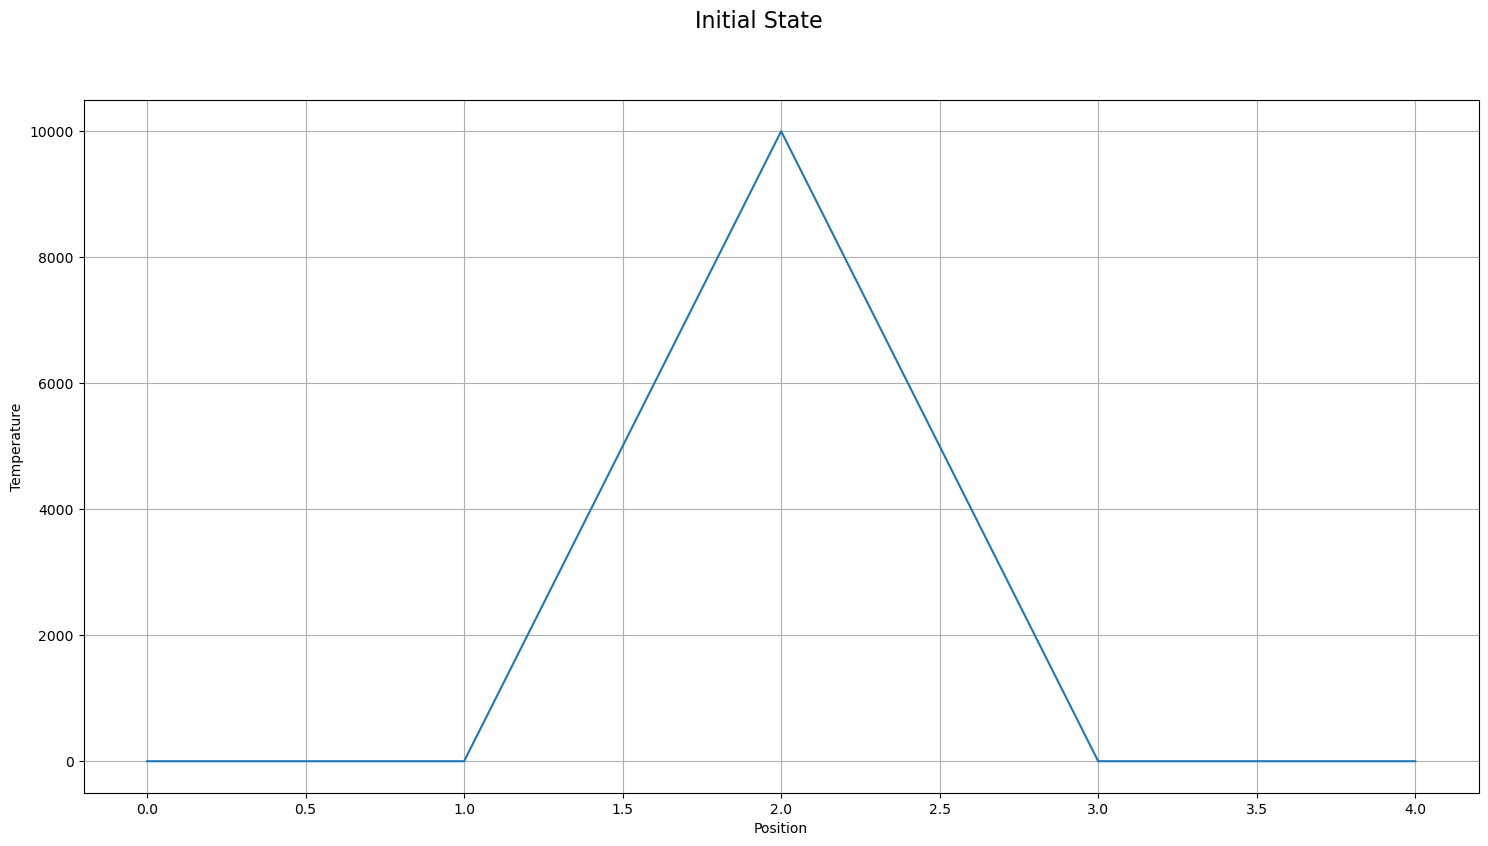

In [35]:

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Initial State", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("Position")
ax.set_ylabel("Temperature")
ax.plot(
    range(len(data)),
    data,
)

ax.grid()

plt.show()


In our kernel each thread will be responsible for managing the temperature update for a single element in a loop over the desired number of timesteps. The kernel is below. Note the use of cooperative group synchronization and the use of two buffers swapped at each iteration to avoid race conditions. See `numba.cuda.cg.this_grid()` for details.

In [36]:
@cuda.jit
def solve_heat_equation(buf_0, buf_1, timesteps, k):

    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    bx = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Domain position
    i = cuda.grid(1)

    print(
        "\nThread id in a 1D block",
        tx,
        "\nBlock id in a 1D grid",
        bx,
        "\nBlock width, i.e. number of threads per block",
        bw,
        "\nDomain position ",
        i,
    )

    # Don't continue if our index is outside the domain

    if i >= len(buf_0):

        return

    # Prepare to do a grid-wide synchronization later

    grid = cuda.cg.this_grid()

    for step in range(timesteps):
        # Select the buffer from the previous timestep

        if (step % 2) == 0:

            data = buf_0

            next_data = buf_1

        else:

            data = buf_1

            next_data = buf_0

        # Get the current temperature associated with this point

        curr_temp = data[i]

        # Apply formula from finite difference equation

        if i == 0:
            # Left wall is held at T = 0

            next_temp = curr_temp + k * (data[i + 1] - (2 * curr_temp))

        elif i == len(data) - 1:
            # Right wall is held at T = 0

            next_temp = curr_temp + k * (data[i - 1] - (2 * curr_temp))

        else:
            # Interior points are a weighted average of their neighbors

            next_temp = curr_temp + k * (data[i - 1] - (2 * curr_temp) + data[i + 1])

        # Write new value to the next buffer

        next_data[i] = next_temp

        # Wait for every thread to write before moving on

        grid.sync()

In [41]:
len(data)

5

In [44]:
threadsperblock = 5
blockspergrid = math.ceil(len(data) / threadsperblock)

print(threadsperblock,blockspergrid)

5 1


In [45]:
solve_heat_equation[blockspergrid,threadsperblock](
    
    buf_0, buf_1, niter, 0.25

)

/home/thiago.esterci/.conda/envs/CuNumba/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))



Thread id in a 1D block 0 
Block id in a 1D grid 0 
Block width, i.e. number of threads per block 5 
Domain position  0

Thread id in a 1D block 1 
Block id in a 1D grid 0 
Block width, i.e. number of threads per block 5 
Domain position  1

Thread id in a 1D block 2 
Block id in a 1D grid 0 
Block width, i.e. number of threads per block 5 
Domain position  2

Thread id in a 1D block 3 
Block id in a 1D grid 0 
Block width, i.e. number of threads per block 5 
Domain position  3

Thread id in a 1D block 4 
Block id in a 1D grid 0 
Block width, i.e. number of threads per block 5 
Domain position  4
